## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations
from test_results import test_results, score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, make_scorer, confusion_matrix, recall_score
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler


import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [3]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


No missing values in all the columns and its only promotion column that's categorical dataset and others are numeric

In [2]:
# check categorical variables counts

cat_variables= ['V1','V4','V5','V6','V7']

for var in cat_variables:
    print(train_data[var].value_counts())

1    31631
2    31608
3    10670
0    10625
Name: V1, dtype: int64
2    57450
1    27084
Name: V4, dtype: int64
3    32743
2    31196
1    15412
4     5183
Name: V5, dtype: int64
3    21186
4    21176
2    21146
1    21026
Name: V6, dtype: int64
2    59317
1    25217
Name: V7, dtype: int64


In [3]:
def make_plot(df,var):
    """" Function to plot the histogram and probability of a particular variable
    Args:
        df(dataframe): datafram for train dataset
        var(string): variable column of interest
    """
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    df[var].hist()
    plt.subplot(1,2,2)
    stats.probplot(df[var], dist='norm', plot=plt)

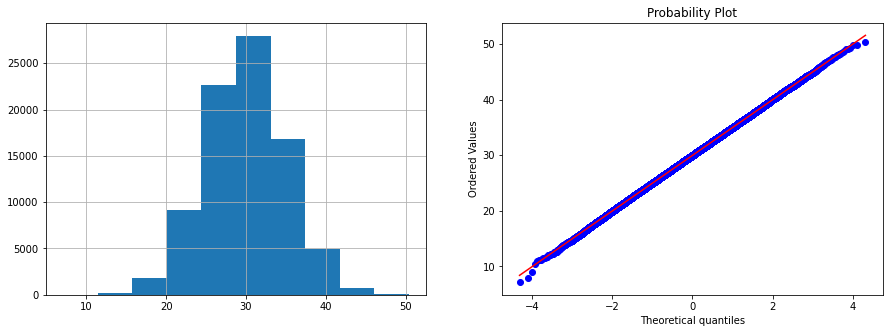

In [4]:
#distribution for V2 numerical variable
make_plot(train_data, 'V2')

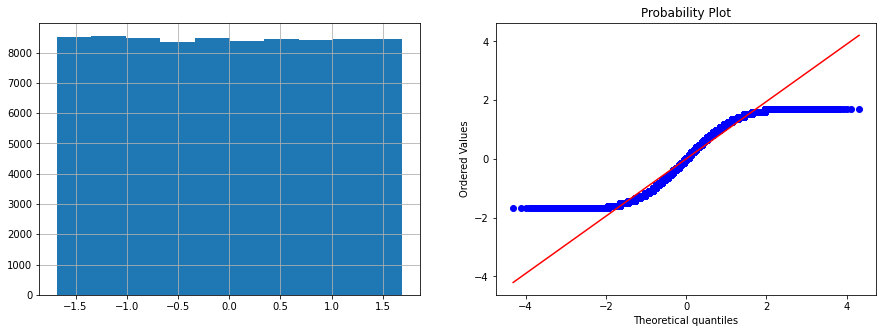

In [7]:
# distribution for V3 numerical variable
make_plot(train_data, 'V3')

## Invariant metric

In [5]:
# overall customers in both control and treatment group
cust_obs= train_data.shape[0]

# customers in control and treatment group
n_obs= train_data.groupby('Promotion').size()
cust_treat= n_obs['Yes']
cust_ctrl= n_obs['No']

print(f'Total customers in both control and treatment: {cust_obs}')
print(f'number of customers in non-promotion group: {cust_ctrl}')
print(f'number of customers in promotion group: {cust_treat}')

Total customers in both control and treatment: 84534
number of customers in non-promotion group: 42170
number of customers in promotion group: 42364


In [6]:
# total number of customers that eventually purchase the product
treat_df= train_data[(train_data['Promotion']=="Yes") & (train_data['purchase']==1)]
ctrl_df= train_data[(train_data['Promotion']=="No") & (train_data['purchase']==1)]
purch_ctrl= ctrl_df.shape[0]
purch_treat= treat_df.shape[0]

print(f'purchasers for promotion group: {purch_treat}')
print(f'purchasers for non-promotion group: {purch_ctrl}')

purchasers for promotion group: 721
purchasers for non-promotion group: 319


In [7]:
# compute the standard deviation, zscore and p-value 
p= 0.5
stdev= np.sqrt(p * (1-p) * cust_obs)
z_score= ((cust_ctrl + 0.5) - p * cust_obs)/ stdev
p_value= 2 * stats.norm.cdf(z_score)

print(f'z-score: {z_score}')
print(f'p-value: {p_value}')

z-score: -0.6638066506192843
p-value: 0.5068140685419046


p-value of 0.507 (z = -0.66), which is within a reasonable range under the null hypothesis. Since we lack sufficient reason to reject the null, we can continue on to evaluating the evaluation metrics.

## Evaluation metrics

In [8]:
# Incremental Response Rate(IRR)
irr= purch_treat/cust_treat - purch_ctrl/cust_ctrl

# Net Incremental Revenue(NIR)
nir= (10 * purch_treat - 0.15 * cust_treat) - 10 * purch_ctrl
print('IRR:', irr)
print('NIR:', nir)

IRR: 0.009454547819772702
NIR: -2334.5999999999995


* The incremental response rate increases is less than 1% and showing little significant effect of customers purchasing the product after receiving promotion offer compare to non-promotion group.
* The net incremental revenue indicates negative value. Hence, the receptive of the promotion offer are likely not the group to have received to the offer because few only purchase after receiving the offers.


In [9]:
# promotion sent to all customers
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promotion= []
    data_point= df.shape[0]
    
    for i in range(data_point):
        promotion.append('Yes')
    
    promotion= np.array(promotion)
    
    return promotion

In [10]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

Our desired minimum IRR is 1.5% (an 0.081% absolute increase in IRR from previous value), and we want to detect this change with a type 1 error rate of 5% and a power of 80%. We need then to find out the size of our data (actually number of customers) to be able to do it.

In [11]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

NormalIndPower().solve_power(effect_size = proportion_effectsize(0.0096, .015), alpha = .05, power = 0.8,
                             alternative = 'smaller')

5089.265513625437

5089 customers are enough to reach our goal of the experiment and we have 84355 observation. We have enough dataset to achieve the goal.

## Models

Our first approach would be to train 2 models.

* on the customers involved in the experiment (promotion), and finding out its profile to purchase.
* on the customers not involved in the promotion, and finding out its profile to purchase.

2 kinds of profiles are then defined. The models try to predict if the customer will purchase or not.

In [12]:
# create the dummies variable of the customer categorical features
cat_variables= ['V1','V4','V5','V6','V7']
for var in cat_variables:
    df_dummies = pd.get_dummies(train_data[var]).rename(columns=lambda x: var + "_" + str(x))
    train_data = pd.concat([train_data, df_dummies], axis=1)
    train_data = train_data.drop(var, axis=1)

print(train_data.head())

   ID Promotion  purchase         V2        V3  V1_0  V1_1  V1_2  V1_3  V4_1  \
0   1        No         0  30.443518 -1.165083     0     0     1     0     1   
1   3        No         0  32.159350 -0.645617     0     0     0     1     0   
2   4        No         0  30.431659  0.133583     0     0     1     0     1   
3   5        No         0  26.588914 -0.212728     1     0     0     0     0   
4   8       Yes         0  28.044331 -0.385883     0     0     0     1     1   

   ...  V5_1  V5_2  V5_3  V5_4  V6_1  V6_2  V6_3  V6_4  V7_1  V7_2  
0  ...     1     0     0     0     0     0     1     0     0     1  
1  ...     0     0     1     0     0     1     0     0     0     1  
2  ...     1     0     0     0     0     0     0     1     0     1  
3  ...     1     0     0     0     0     0     0     1     0     1  
4  ...     1     0     0     0     0     1     0     0     0     1  

[5 rows x 21 columns]


In [13]:
treat_df= train_data[(train_data['Promotion']=="Yes") & (train_data['purchase']==1)].shape[0]
ctrl_df= train_data[(train_data['Promotion']=="No") & (train_data['purchase']==1)].shape[0]
print(f"Treatment(promotion) group: {treat_df}/{cust_treat}")
print(f"Control(non-promotion) group: {ctrl_df}/{cust_ctrl}")

Treatment(promotion) group: 721/42364
Control(non-promotion) group: 319/42170


The data is inbalanced, there is largely more "no purchase" than "yes purchase". The classification from our models won't work. We have to use common techniques to balance the data. We will use here the SMOTE method.

In [14]:
#customers on promotion and non-promotion groups
cust_treat_df= train_data[train_data['Promotion']=="Yes"]
cust_ctrl_df= train_data[train_data['Promotion']=="No"]

variables = ['V2', 'V3', 'V1_0', 'V1_1', 'V1_2',
            'V1_3', 'V4_1', 'V4_2', 'V5_1', 'V5_2',
            'V5_3', 'V5_4', 'V6_1', 'V6_2','V6_3',
            'V6_4', 'V7_1', 'V7_2']

# define X,y for promotion group for model
X_treat = cust_treat_df[variables]
y_treat = cust_treat_df['purchase']

# define X,y for non-promotion group for model
X_ctrl = cust_ctrl_df[variables]
y_ctrl = cust_ctrl_df['purchase']

# split the dataset into train and test dataset on the 2 groups
X_treat_train, X_treat_test, y_treat_train, y_treat_test = train_test_split(X_treat, y_treat, test_size=0.3, random_state=42)
X_ctrl_train, X_ctrl_test, y_ctrl_train, y_ctrl_test = train_test_split(X_ctrl, y_ctrl, test_size=0.3, random_state=42)

In [15]:
# balance the dataset
smt = SMOTE()

# for the treatment(promotion) model
X_treat_train, y_treat_train = smt.fit_resample(X_treat_train, y_treat_train)
X_treat_train = pd.DataFrame(X_treat_train, columns=variables)
y_treat_train = pd.Series(y_treat_train)

# for the control(non-promotion) model
X_ctrl_train, y_ctrl_train = smt.fit_resample(X_ctrl_train, y_ctrl_train)
X_ctrl_train = pd.DataFrame(X_ctrl_train, columns=variables)
y_ctrl_train = pd.Series(y_ctrl_train)

In [16]:
y_treat_train.value_counts()

0    29165
1    29165
Name: purchase, dtype: int64

In [17]:
# define scorer function for models based on specificity

def scorer_optim(y_true, y_pred):
    '''
    Scorer function for our models.
    Args: 
        y_true: DataFrame of true values.
        y_pred: DataFrame of predicted values.
    Return:
        b_acc + spe + rec: scorer value
    '''
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # accuracy score
    accuracy = accuracy_score(y_true, y_pred) * 0.20
    
    # recall score
    rec = recall_score(y_true, y_pred) * 0.20
    
    # specificity - false positive
    spe = conf_matrix[0,0]/conf_matrix[0,:].sum() * 0.8
    
    #select perfect specificity
    if spe < 0.8:
        spe -= 0.1
    return rec + spe 

#scorer for the models
optimize = make_scorer(scorer_optim)
accuracy = make_scorer(accuracy_score)

def score_optimization(model, params, clf, X_train, y_train, X_test, y_test):
    
    start = time()
    
    # instantiate pipeline class
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf )
    ])
    
    # instantiate gridsearchcv
    search = GridSearchCV(
        pipeline,
        params,
        n_jobs=1,
        scoring=optimize
    )

    # train the model
    search.fit(X_train, y_train)
    
    # heading
    print('\n','-'*40,'\n', model.upper() + " MODEL",'\n','-'*40)
    print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)

    # define best estimator
    best = search.best_estimator_
    print('Best parameters: \n\n',search.best_params_,'\n')

    #cross validate on train data
    print("TRAIN GROUP")
    train_cv = cross_val_score(X=X_train, y=y_train, 
                               estimator=best, scoring=accuracy,cv=3)
    print("\nCross-validation recall scores:",train_cv)
    print("Mean accuracy score:",train_cv.mean())

    # make a predict with test data
    print("\nTEST GROUP")
    y_pred = best.fit(X_train, y_train).predict(X_test)
    print("\nAccuracy Score:",accuracy_score(y_test,y_pred),"\n")

    # classification report 
    print(classification_report(y_test, y_pred))

    # plot the confusion matrix metric
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()

    # store result
    performance.loc[clf.__class__.__name__+ "_" + model.lower(),:] = [
        train_cv.mean(),
        accuracy_score(y_test,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum(),
        recall_score(y_test,y_pred),
        scorer_optim(y_test,y_pred)
    ]
    # display result
    display(pd.DataFrame(search.cv_results_).iloc[:,4:].sort_values(by='rank_test_score').head())
    display(performance)
    
    end = time()
    print("Executed time: {}s".format(round(end - start,2)))
    return best
    
# dataframe to store model metrics
performance = pd.DataFrame(columns=['Train_Accuracy', 'Test_Accuracy', 'Test_Specification', 'Test_Recall'])

performance['Optimize'] = []

model_lists = {}


 ---------------------------------------- 
 2 MODELS - TREATMENT MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LinearSVC 
 ----------------------------------------
Best parameters: 

 {'clf__C': 5e-05, 'clf__class_weight': {1: 7}, 'clf__loss': 'squared_hinge', 'clf__max_iter': 500, 'clf__random_state': 25} 

TRAIN GROUP

Cross-validation recall scores: [0.65336351 0.63446999 0.63148691]
Mean accuracy score: 0.6397734683689854

TEST GROUP

Accuracy Score: 0.35436664044059796 

              precision    recall  f1-score   support

           0       0.99      0.34      0.51     12478
           1       0.02      0.89      0.05       232

    accuracy                           0.35     12710
   macro avg       0.51      0.62      0.28     12710
weighted avg       0.98      0.35      0.50     12710



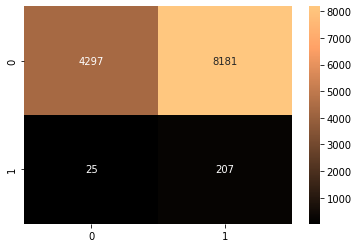

,param_clf__C,param_clf__class_weight,param_clf__loss,param_clf__max_iter,param_clf__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.00005,{1: 7},squared_hinge,500,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.376359,0.338574,0.343031,0.333842,0.336894,0.34574,0.015595,1
1,0.00005,{1: 7},squared_hinge,500,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.376359,0.338574,0.343031,0.333842,0.336894,0.34574,0.015595,1
2,0.00005,{1: 7},squared_hinge,500,60,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.376359,0.338574,0.343031,0.333842,0.336894,0.34574,0.015595,1
3,0.00005,{1: 7},squared_hinge,1000,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.376359,0.338574,0.343031,0.333842,0.336894,0.34574,0.015595,1
4,0.00005,{1: 7},squared_hinge,1000,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.376359,0.338574,0.343031,0.333842,0.336894,0.34574,0.015595,1


,Train_Accuracy,Test_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.639773,0.354367,0.344366,0.892241,0.353941


Executed time: 19.83s

 ---------------------------------------- 
 2 MODELS - CONTROL MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LinearSVC 
 ----------------------------------------
Best parameters: 

 {'clf__C': 5e-05, 'clf__class_weight': {1: 7}, 'clf__loss': 'squared_hinge', 'clf__max_iter': 500, 'clf__random_state': 25} 

TRAIN GROUP

Cross-validation recall scores: [0.72449084 0.71435882 0.71492171]
Mean accuracy score: 0.7179237880803738

TEST GROUP

Accuracy Score: 0.5142676468263379 

              precision    recall  f1-score   support

           0       0.99      0.51      0.68     12538
           1       0.01      0.43      0.02       113

    accuracy                           0.51     12651
   macro avg       0.50      0.47      0.35     12651
weighted avg       0.98      0.51      0.67     12651



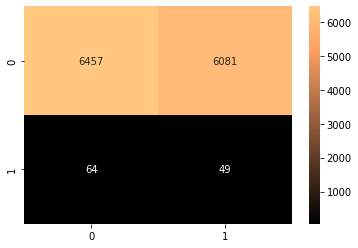

,param_clf__C,param_clf__class_weight,param_clf__loss,param_clf__max_iter,param_clf__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.00005,{1: 7},squared_hinge,500,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.484649,0.471209,0.472232,0.476493,0.471375,0.475192,0.005105,1
1,0.00005,{1: 7},squared_hinge,500,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.484649,0.471209,0.472232,0.476493,0.471375,0.475192,0.005105,1
2,0.00005,{1: 7},squared_hinge,500,60,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.484649,0.471209,0.472232,0.476493,0.471375,0.475192,0.005105,1
3,0.00005,{1: 7},squared_hinge,1000,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.484649,0.471209,0.472232,0.476493,0.471375,0.475192,0.005105,1
4,0.00005,{1: 7},squared_hinge,1000,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.484649,0.471209,0.472232,0.476493,0.471375,0.475192,0.005105,1


,Train_Accuracy,Test_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.639773,0.354367,0.344366,0.892241,0.353941
LinearSVC_2 models - control,0.717924,0.514268,0.514994,0.433628,0.398721


Executed time: 18.9s


In [18]:
from time import time
# Model 1 - LinearSVC()

params_LSVC = {
    'clf__loss' : ['squared_hinge'],
    'clf__C': [5e-5, 5e-6],
    'clf__random_state' : [25, 42, 60],
    'clf__max_iter' : [500, 1000],
    'clf__class_weight' : [{1 : 7}, {1 : 8}],   
    }

clf_LSVC = LinearSVC()

model_lists['LinearSVC_treat_2models'] = score_optimization(model="2 models - treatment", clf=clf_LSVC, params=params_LSVC,
                   X_train=X_treat_train, y_train=y_treat_train, 
                   X_test=X_treat_test, y_test=y_treat_test)

model_lists['LinearSVC_ctrl_2models'] = score_optimization(model="2 models - control", clf=clf_LSVC, params=params_LSVC,
                   X_train=X_ctrl_train, y_train=y_ctrl_train, 
                   X_test=X_ctrl_test, y_test=y_ctrl_test)


 ---------------------------------------- 
 2 MODELS - TREATMENT MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: 

 {'clf__C': 1000.0, 'clf__class_weight': {1: 10}, 'clf__penalty': 'l2', 'clf__random_state': 60, 'clf__solver': 'saga', 'clf__tol': 1} 

TRAIN GROUP

Cross-validation recall scores: [0.81408146 0.73126575 0.75374171]
Mean accuracy score: 0.7663629741386838

TEST GROUP

Accuracy Score: 0.5619984264358773 

              precision    recall  f1-score   support

           0       0.99      0.56      0.72     12478
           1       0.02      0.59      0.05       232

    accuracy                           0.56     12710
   macro avg       0.51      0.58      0.38     12710
weighted avg       0.97      0.56      0.70     12710



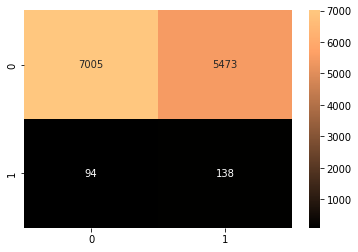

,param_clf__C,param_clf__class_weight,param_clf__penalty,param_clf__random_state,param_clf__solver,param_clf__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,1000.0,{1: 10},l2,60,saga,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.546220,0.570495,0.549751,0.548620,0.561409,0.555299,0.009231,1
34,10000.0,{1: 10},l2,60,saga,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.546220,0.570495,0.549751,0.548620,0.561409,0.555299,0.009231,1
2,1000.0,{1: 10},l2,25,newton-cg,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.598406,0.540768,0.552803,0.540699,0.541831,0.554901,0.022223,3
5,1000.0,{1: 10},l2,42,newton-cg,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.598406,0.540768,0.552803,0.540699,0.541831,0.554901,0.022223,3
32,10000.0,{1: 10},l2,42,newton-cg,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.598406,0.540768,0.552803,0.540699,0.541831,0.554901,0.022223,3


,Train_Accuracy,Test_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.639773,0.354367,0.344366,0.892241,0.353941
LinearSVC_2 models - control,0.717924,0.514268,0.514994,0.433628,0.398721
LinearSVC_1,0.697692,0.440795,0.437771,0.786364,0.407490
LogisticRegression_2 models - treatment,0.766363,0.561998,0.561388,0.594828,0.468076


Executed time: 40.17s

 ---------------------------------------- 
 2 MODELS - CONTROL MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: 

 {'clf__C': 1000.0, 'clf__class_weight': {1: 10}, 'clf__penalty': 'l2', 'clf__random_state': 25, 'clf__solver': 'saga', 'clf__tol': 1} 

TRAIN GROUP

Cross-validation recall scores: [0.81388804 0.80728687 0.76578651]
Mean accuracy score: 0.7956538054787977

TEST GROUP

Accuracy Score: 0.5594024187811241 

              precision    recall  f1-score   support

           0       0.99      0.56      0.72     12538
           1       0.01      0.43      0.02       113

    accuracy                           0.56     12651
   macro avg       0.50      0.50      0.37     12651
weighted avg       0.98      0.56      0.71     12651



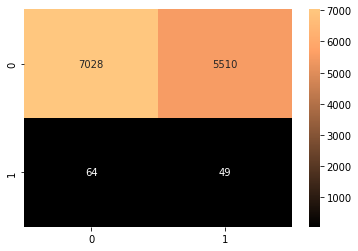

,param_clf__C,param_clf__class_weight,param_clf__penalty,param_clf__random_state,param_clf__solver,param_clf__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,1000.0,{1: 10},l2,25,saga,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.578799,0.652070,0.642485,0.590686,0.657149,0.624238,0.032806,1
28,10000.0,{1: 10},l2,25,saga,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.578663,0.652070,0.642485,0.590686,0.657149,0.624211,0.032844,2
7,1000.0,{1: 10},l2,60,saga,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.661146,0.675814,0.534862,0.569806,0.619653,0.612256,0.053435,3
34,10000.0,{1: 10},l2,60,saga,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.661146,0.675814,0.534862,0.569670,0.619653,0.612229,0.053456,4
32,10000.0,{1: 10},l2,42,newton-cg,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.603258,0.610694,0.601313,0.600307,0.605937,0.604302,0.003729,5


,Train_Accuracy,Test_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.639773,0.354367,0.344366,0.892241,0.353941
LinearSVC_2 models - control,0.717924,0.514268,0.514994,0.433628,0.398721
LinearSVC_1,0.697692,0.440795,0.437771,0.786364,0.407490
LogisticRegression_2 models - treatment,0.766363,0.561998,0.561388,0.594828,0.468076
LogisticRegression_2 models - control,0.795654,0.559402,0.560536,0.433628,0.435154


Executed time: 38.78s


In [25]:
# Model 2 - LogisticRegression()

params_LR = [{
    'clf__solver': ['liblinear','saga', 'newton-cg'],
    'clf__C': [1e3, 1e4],
    'clf__penalty': ['l2'],
    'clf__random_state' : [25, 42, 60],
    'clf__class_weight': [{1 : 10}, {1 : 25}, {1 : 50}],
    'clf__tol' : [1]
}]

clf_LR = LogisticRegression(
    n_jobs=1 
)

model_lists['LogisticRegression_treat_2models'] = score_optimization(model="2 models - treatment", clf=clf_LR,params=params_LR,X_train=X_treat_train, 
                   y_train=y_treat_train, X_test=X_treat_test, y_test=y_treat_test)
model_lists['LogisticRegression_ctrl_2models'] = score_optimization(model="2 models - control",clf=clf_LR,params=params_LR,X_train=X_ctrl_train, 
                   y_train=y_ctrl_train, X_test=X_ctrl_test, y_test=y_ctrl_test)

In [23]:
#pick best model
best_model_treat= model_lists['LogisticRegression_treat_2models']
best_model_ctrl= model_lists['LogisticRegression_ctrl_2models']

In [24]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    # create dummies variables for the categorical variables

    for var in cat_variables:
        df_dummies = pd.get_dummies(test[var]).rename(columns=lambda x: var + "_" + str(x))
        test = pd.concat([test, df_dummies], axis=1)
        test = test.drop(var, axis=1)
    
    pred_probs_ctrl = best_model_ctrl.predict_proba(test)

    pred_probs_treat = best_model_treat.predict_proba(test)

    # get difference in probabilities between experimental and control model for purchase = 1 label
    lift = abs(pred_probs_treat[:,1] - pred_probs_ctrl[:,1])

    promotion = []
    
    # Only send promotions to top 3 percentile of probabilities
    cutoff_lift = np.percentile(lift, 97)
    
    for prob in lift:
        if prob > 0:
            if prob > cutoff_lift:
                promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [25]:
# test the promotion

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0116.

Your nir with this strategy is -21.50.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.011629098360655739, -21.5)

## model for customers in promotion who made purchase

In this approach, we will assign labels of 1 to those who received the promotions and made purchases, and labels of 0 to everyone else. In other words, we want the model to find the individuals who are likely to purchase only after they received a promotion.

In [30]:
# renaming the dataframe and create a new column
train_data_1model = train_data.copy()

train_data_1model['Receptive'] = 0

# assign 1 to customers who are in promotion group and also purchase the product
train_data_1model.loc[train_data_1model[(train_data_1model['Promotion'] == 'Yes') & (train_data_1model['purchase'] == 1)].index, 'Receptive'] = 1
train_data_1model[train_data_1model['Receptive']==1]

,ID,Promotion,purchase,V2,V3,V1_0,V1_1,V1_2,V1_3,V4_1,...,V5_2,V5_3,V5_4,V6_1,V6_2,V6_3,V6_4,V7_1,V7_2,Receptive
107,162,Yes,1,33.030562,-0.732194,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
328,503,Yes,1,31.760033,1.518828,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,1
352,534,Yes,1,17.512709,1.259095,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,1
383,580,Yes,1,31.043736,-1.338239,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,1
443,661,Yes,1,26.775416,1.432250,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84299,125803,Yes,1,35.496938,-0.039572,0,0,0,1,0,...,0,0,1,0,1,0,0,0,1,1
84300,125804,Yes,1,34.289793,0.047006,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,1
84314,125828,Yes,1,33.966419,1.605406,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
84388,125954,Yes,1,31.100225,-1.165083,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,1


In [31]:
# define X variable column list        
variables = ['V2', 'V3', 'V1_0', 'V1_1', 'V1_2',
            'V1_3', 'V4_1', 'V4_2', 'V5_1', 'V5_2',
            'V5_3', 'V5_4', 'V6_1', 'V6_2','V6_3',
            'V6_4', 'V7_1', 'V7_2']

# X,y
X = train_data_1model[variables]
y = train_data_1model['Receptive']

# split data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
# balance the data 
smt = SMOTE()

X_train, y_train = smt.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=variables)
y_train = pd.Series(y_train)


 ---------------------------------------- 
 1 MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LinearSVC 
 ----------------------------------------
Best parameters: 

 {'clf__C': 5e-05, 'clf__class_weight': {1: 7}, 'clf__loss': 'squared_hinge', 'clf__max_iter': 500, 'clf__random_state': 25} 

TRAIN GROUP

Cross-validation recall scores: [0.69924581 0.69206187 0.696298  ]
Mean accuracy score: 0.6958685610635368

TEST GROUP

Accuracy Score: 0.4377193328338788 

              precision    recall  f1-score   support

           0       1.00      0.43      0.61     25141
           1       0.01      0.79      0.02       220

    accuracy                           0.44     25361
   macro avg       0.50      0.61      0.31     25361
weighted avg       0.99      0.44      0.60     25361



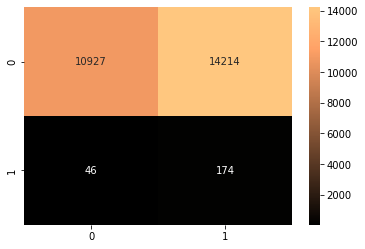

,param_clf__C,param_clf__class_weight,param_clf__loss,param_clf__max_iter,param_clf__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.00005,{1: 7},squared_hinge,500,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.433958,0.425743,0.423675,0.424459,0.430987,0.427764,0.004012,1
1,0.00005,{1: 7},squared_hinge,500,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.433958,0.425743,0.423675,0.424459,0.430987,0.427764,0.004012,1
2,0.00005,{1: 7},squared_hinge,500,60,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.433958,0.425743,0.423675,0.424459,0.430987,0.427764,0.004012,1
3,0.00005,{1: 7},squared_hinge,1000,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.433958,0.425743,0.423675,0.424459,0.430987,0.427764,0.004012,1
4,0.00005,{1: 7},squared_hinge,1000,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.433958,0.425743,0.423675,0.424459,0.430987,0.427764,0.004012,1


,Train_Accuracy,Test_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.639773,0.354367,0.344366,0.892241,0.353941
LinearSVC_2 models - control,0.717924,0.514268,0.514994,0.433628,0.398721
LinearSVC_1,0.695869,0.437719,0.434629,0.790909,0.405885
LogisticRegression_2 models - treatment,0.766363,0.561998,0.561388,0.594828,0.468076
LogisticRegression_2 models - control,0.795654,0.559402,0.560536,0.433628,0.435154
LogisticRegression_1,0.760968,0.417215,0.415497,0.613636,0.355125


Executed time: 39.41s


In [33]:
# Model 1 - LinearSVC()

model_lists['LinearSVC_1model'] = score_optimization(model="1", clf=clf_LSVC, params=params_LSVC,
                   X_train=X_train, y_train=y_train, 
                   X_test=X_test, y_test=y_test)


 ---------------------------------------- 
 1 MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: 

 {'clf__C': 1000.0, 'clf__class_weight': {1: 10}, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'saga', 'clf__tol': 1} 

TRAIN GROUP

Cross-validation recall scores: [0.73818228 0.74022753 0.74057882]
Mean accuracy score: 0.7396628793627413

TEST GROUP

Accuracy Score: 0.6429162887898742 

              precision    recall  f1-score   support

           0       0.99      0.64      0.78     25141
           1       0.01      0.58      0.03       220

    accuracy                           0.64     25361
   macro avg       0.50      0.61      0.40     25361
weighted avg       0.99      0.64      0.77     25361



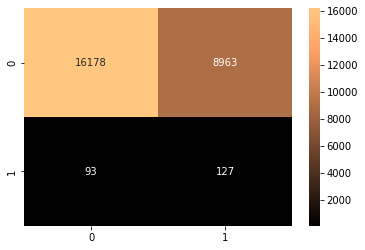

,param_clf__C,param_clf__class_weight,param_clf__penalty,param_clf__random_state,param_clf__solver,param_clf__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,1000.0,{1: 10},l2,42,saga,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.621789,0.632798,0.544555,0.540481,0.485427,0.565010,0.055087,1
31,10000.0,{1: 10},l2,42,saga,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.621789,0.632798,0.544555,0.540481,0.485427,0.565010,0.055087,1
34,10000.0,{1: 10},l2,60,saga,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.573659,0.494171,0.569167,0.569133,0.507073,0.542641,0.034589,3
7,1000.0,{1: 10},l2,60,saga,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.573591,0.494171,0.569167,0.569133,0.507073,0.542627,0.034577,4
1,1000.0,{1: 10},l2,25,saga,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.502795,0.481559,0.593728,0.551015,0.485955,0.523010,0.043093,5


,Train_Accuracy,Test_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.639773,0.354367,0.344366,0.892241,0.353941
LinearSVC_2 models - control,0.717924,0.514268,0.514994,0.433628,0.398721
LinearSVC_1,0.695869,0.437719,0.434629,0.790909,0.405885
LogisticRegression_2 models - treatment,0.766363,0.561998,0.561388,0.594828,0.468076
LogisticRegression_2 models - control,0.795654,0.559402,0.560536,0.433628,0.435154
LogisticRegression_1,0.739663,0.642916,0.643491,0.577273,0.530247


Executed time: 76.24s


In [34]:
# Model 2 - LogisticRegression()

model_lists['LogisticRegression_1model'] = score_optimization(model="1", clf=clf_LR, params=params_LR,
                   X_train=X_train, y_train=y_train, 
                   X_test=X_test, y_test=y_test)

In [35]:
# pick best model
best_model= model_lists['LogisticRegression_1model']

In [36]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    # create dummies variables

    for var in cat_variables:
        df_dummies = pd.get_dummies(test[var]).rename(columns=lambda x: var + "_" + str(x))
        test = pd.concat([test, df_dummies], axis=1)
        test = test.drop(var, axis=1)
    
    y_preds = best_model.predict(test)

    promotion = []
    
    for pred in y_preds:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [37]:
# test the function of promotion strategy

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0191.

Your nir with this strategy is 297.90.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019110495319487764, 297.9000000000001)